In [56]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result
db, conn = pgconnect(credentials)

Connected successfully.


In [57]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import numpy as np
import os

In [58]:
query(conn, "select PostGIS_Version()")

srid = 4326
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [59]:
conn.execute(text("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2(
    "SA2_CODE21" INTEGER NOT NULL,
    "SA2_NAME21" VARCHAR(100),
    "CHG_FLAG21" INTEGER,
    "CHG_LBL21" VARCHAR(100),
    "SA3_CODE21" INTEGER,
    "SA3_NAME21" VARCHAR(100),
    "SA4_CODE21" INTEGER,
    "SA4_NAME21" VARCHAR(100),
    "GCC_CODE21" VARCHAR(100),
    "GCC_NAME21" VARCHAR(100),
    "STE_CODE21" INTEGER,
    "STE_NAME21" VARCHAR(100),
    "AUS_CODE21" VARCHAR(100),
    "AUS_NAME21" VARCHAR(100),
    "AREASQKM21" FLOAT,
    "LOCI_URI21" VARCHAR(100),
    "PRIORITY" VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326),
    CONSTRAINT "PK_sa2" PRIMARY KEY ("SA2_CODE21")
);
COMMIT;"""
))

In [60]:
sa2 = gpd.read_file("SA2/SA2_2021_AUST_GDA2020.shp")
sa2 = sa2[sa2['GCC_NAME21'] == 'Greater Sydney']
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
sa2 = sa2.drop(columns="geometry")
sa2

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geom
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.03954821100714 -34.0417452...


In [61]:
sa2.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2")

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,PRIORITY,geom
0,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E6100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E61000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E61000000200000001030000000100000085...
3,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E61000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E6100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E61000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E61000000100000001030000000100000089...
370,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E6100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None,0106000020E610000001000000010300000001000000A1...


In [62]:
conn.execute(text("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses(
    industry_code VARCHAR(100),
    industry_name VARCHAR(100),
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    "0_to_50k_businesses" INTEGER,
    "50k_to_200k_businesses" INTEGER,
    "200k_to_2m_businesses" INTEGER,
    "2m_to_5m_businesses" INTEGER,
    "5m_to_10m_businesses" INTEGER,
    "10m_or_more_businesses" INTEGER,
    total_businesses INTEGER,
    CONSTRAINT "PK_businesses" PRIMARY KEY ("sa2_code")
);
COMMIT;"""
))

In [63]:
businesses = pd.read_csv('Businesses.csv')
businesses = businesses.dropna()
businesses

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


In [64]:
businesses.to_sql('businesses', conn, if_exists = 'replace', index = False)
query(conn, "select * from businesses")

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


In [65]:
conn.execute(text("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops(
    stop_id VARCHAR(100),
    stop_code FLOAT,
    stop_name VARCHAR(100) NOT NULL,
    location_type FLOAT,
    parent_station VARCHAR(100),
    wheelchair_boarding INTEGER,
    platform_code VARCHAR(100),
    geom GEOMETRY(POINT,4326),
    CONSTRAINT "PK_stops" PRIMARY KEY ("stop_id")
);
COMMIT;"""
))

In [66]:
stops = pd.read_csv('Stops.txt', quotechar='"')
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops = stops.drop(columns=['stop_lon', 'stop_lat'])
srid = 4326
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
stops

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,NaN,POINT (151.20666465471 -33.8822064874687)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,NaN,POINT (151.20699145565 -33.8820421431408)
2,200060,NaN,Central Station,1.0,NaN,0,NaN,POINT (151.206292455081 -33.8840842535493)
3,201510,NaN,Redfern Station,1.0,NaN,0,NaN,POINT (151.198866071817 -33.8916900512711)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,NaN,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,POINT (151.07879697831 -33.8220164586429)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1,1A,POINT (151.116926480557 -33.8406690716775)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1,1B,POINT (151.116898892402 -33.8407691073139)
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1,NaN,POINT (151.010576673346 -33.8139042429414)


In [67]:
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from stops")

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,None,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,None,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,NaN,Central Station,1.0,None,0,None,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,NaN,Redfern Station,1.0,None,0,None,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,None,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1,1A,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1,1B,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1,None,0101000020E6100000E443E4A456E0624025C1A4032EE8...


In [68]:
conn.execute(text("""
DROP TABLE IF EXISTS polls;
CREATE TABLE polls(
    "FID" VARCHAR(255),
    state VARCHAR(100) NOT NULL,
    division_id INTEGER NOT NULL,
    division_name VARCHAR(100) NOT NULL,
    polling_place_id INTEGER NOT NULL,
    polling_place_type_id INTEGER NOT NULL,
    polling_place_name VARCHAR(100) NOT NULL,
    premises_name VARCHAR(100) NOT NULL,
    premises_address_1 VARCHAR(100),
    premises_address_2 VARCHAR(100),
    premises_address_3 VARCHAR(100),
    premises_suburb VARCHAR(100),
    premises_state_abbreviation VARCHAR(100),
    premises_post_code FLOAT,
    geom GEOMETRY(POINT,4326),
    CONSTRAINT "PK_polls" PRIMARY KEY ("polling_place_id")
);
COMMIT;"""
))

In [69]:
polls = pd.read_csv('PollingPlaces2019.csv')
polls = polls[polls['latitude'].notna() & polls['longitude'].notna()]
polls['geom'] = gpd.points_from_xy(polls.longitude, polls.latitude)
polls = polls.drop(columns=['longitude', 'latitude', 'the_geom'])
srid = 4326
polls['geom'] = polls['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
polls

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geom
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,NaN,NaN,OATLEY,NSW,2223.0,POINT (151.081 -33.9847)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,NaN,NaN,DHARRUK,NSW,2770.0,POINT (150.817 -33.7475)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,NaN,NaN,ALLAWAH,NSW,2218.0,POINT (151.1148974 -33.9767897)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,NaN,NaN,SOUTH HURSTVILLE,NSW,2221.0,POINT (151.111 -33.9756)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,NaN,NaN,BEVERLY HILLS,NSW,2209.0,POINT (151.075 -33.9413)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2810,1,Warilla North,Warilla North Community Centre,2-6 Hill St,NaN,NaN,WARILLA,NSW,2528.0,POINT (150.85177 -34.54724)
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,POINT (150.424 -34.4409)


In [70]:
polls.to_sql('polls', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from polls")

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,None,None,OATLEY,NSW,2223.0,0101000020E61000003BDF4F8D97E26240832F4CA60AFE...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,None,None,DHARRUK,NSW,2770.0,0101000020E6100000A01A2FDD24DA624048E17A14AEDF...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,None,None,ALLAWAH,NSW,2218.0,0101000020E6100000A7EC4F3DADE36240EA48E47107FD...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,None,None,SOUTH HURSTVILLE,NSW,2221.0,0101000020E6100000643BDF4F8DE3624022FDF675E0FC...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,None,None,BEVERLY HILLS,NSW,2209.0,0101000020E61000006666666666E26240C6DCB5847CF8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2810,1,Warilla North,Warilla North Community Centre,2-6 Hill St,None,None,WARILLA,NSW,2528.0,0101000020E6100000D8B628B341DB62401288D7F50B46...
2786,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,None,None,BARRACK HEIGHTS,NSW,2528.0,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2787,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,None,None,None,WARILLA,NSW,2528.0,0101000020E6100000BD32141C83DB624011F28B5C8146...
2788,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,None,None,WELBY,NSW,2575.0,0101000020E610000021B0726891CD6240386744696F38...


In [71]:
conn.execute(text("""
DROP TABLE IF EXISTS catchments_primary;
CREATE TABLE catchments_primary(
    "USE_ID" INTEGER NOT NULL,
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" INTEGER,
    "KINDERGART" VARCHAR(10),
    "YEAR1" VARCHAR(10),
    "YEAR2" VARCHAR(10),
    "YEAR3" VARCHAR(10),
    "YEAR4" VARCHAR(10),
    "YEAR5" VARCHAR(10),
    "YEAR6" VARCHAR(10),
    "YEAR7" VARCHAR(10),
    "YEAR8" VARCHAR(10),
    "YEAR9" VARCHAR(10),
    "YEAR10" VARCHAR(10),
    "YEAR11" VARCHAR(10),
    "YEAR12" VARCHAR(10),
    "PRIORITY" VARCHAR(10),
    geom GEOMETRY(MULTIPOLYGON,4326),
    CONSTRAINT "PK_catchments_primary" PRIMARY KEY ("USE_ID")
);
COMMIT;"""
))

In [72]:
catchments_primary = gpd.read_file('catchments/catchments_primary.shp')
catchments_primary = catchments_primary[catchments_primary['geometry'].notna()]
catchments_primary['geom'] = catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
catchments_primary = catchments_primary.drop(columns="geometry")
catchments_primary

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((147.9462089946497 -34.55863148...
1658,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((148.12885348977485 -35.6008184...
1659,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((146.86147943204122 -35.8751106...
1660,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((145.18402754685187 -29.6580498...


In [73]:
catchments_primary.to_sql('catchments_primary', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from catchments_primary")

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000065...
3,7308,PRIMARY,Plattsburg PS,20200723.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E6100000010000000103000000010000003D...
4,4615,PRIMARY,Caddies Ck PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000056...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,2409,PRIMARY,Lismore SPS,20200616.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000C9...
1658,4383,PRIMARY,E A Southee PS,20200315.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000B9...
1659,3275,PRIMARY,Tumbarumba PS,20200507.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000C0...
1660,2239,PRIMARY,Jindera PS,20200507.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000F6...


In [74]:
conn.execute(text("""
DROP TABLE IF EXISTS catchments_secondary;
CREATE TABLE catchments_secondary(
    "USE_ID" INTEGER NOT NULL,
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" INTEGER,
    "KINDERGART" VARCHAR(10),
    "YEAR1" VARCHAR(10),
    "YEAR2" VARCHAR(10),
    "YEAR3" VARCHAR(10),
    "YEAR4" VARCHAR(10),
    "YEAR5" VARCHAR(10),
    "YEAR6" VARCHAR(10),
    "YEAR7" VARCHAR(10),
    "YEAR8" VARCHAR(10),
    "YEAR9" VARCHAR(10),
    "YEAR10" VARCHAR(10),
    "YEAR11" VARCHAR(10),
    "YEAR12" VARCHAR(10),
    "PRIORITY" VARCHAR(10),
    geom GEOMETRY(MULTIPOLYGON,4326),
    CONSTRAINT "PK_catchments_secondary" PRIMARY KEY ("USE_ID")
);
COMMIT;"""
))

In [75]:
catchments_secondary = gpd.read_file('catchments/catchments_secondary.shp')
catchments_secondary = catchments_secondary[catchments_secondary['geometry'].notna()]
catchments_secondary['geom'] = catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
catchments_secondary = catchments_secondary.drop(columns="geometry")
catchments_secondary

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.67182402032344 -35.3144375...
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((147.08733806259178 -35.8627146...
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.81447829547324 -35.7834062...
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((150.68599834118749 -33.7403060...
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((150.69513440644116 -33.7562688...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,20211221,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((151.05363508494244 -33.8507612...
432,8108,HIGH_COED,Cessnock HS,20230405,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((151.4285214252146 -32.74415247...
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((143.37723402388323 -34.8017260...
434,1115,CENTRAL_HIGH,Balranald CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((143.65540852703225 -33.5570248...


In [76]:
catchments_secondary.to_sql('catchments_secondary', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from catchments_secondary")

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,8503,HIGH_COED,Billabong HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E61000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,20201016.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,20211115.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,20211221.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E61000000100000001030000000100000040...
432,8108,HIGH_COED,Cessnock HS,20230405.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E610000001000000010300000001000000AD...
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003E...
434,1115,CENTRAL_HIGH,Balranald CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000005B...


In [77]:
conn.execute(text("""
DROP TABLE IF EXISTS catchments_future;
CREATE TABLE catchments_future(
    "USE_ID" INTEGER NOT NULL,
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" INTEGER,
    "KINDERGART" VARCHAR(10),
    "YEAR1" VARCHAR(10),
    "YEAR2" VARCHAR(10),
    "YEAR3" VARCHAR(10),
    "YEAR4" VARCHAR(10),
    "YEAR5" VARCHAR(10),
    "YEAR6" VARCHAR(10),
    "YEAR7" VARCHAR(10),
    "YEAR8" VARCHAR(10),
    "YEAR9" VARCHAR(10),
    "YEAR10" VARCHAR(10),
    "YEAR11" VARCHAR(10),
    "YEAR12" VARCHAR(10),
    "PRIORITY" VARCHAR(10),
    geom GEOMETRY(MULTIPOLYGON,4326),
    CONSTRAINT "PK_catchments_future" PRIMARY KEY ("USE_ID")
);
COMMIT;"""
))

In [78]:
catchments_future = gpd.read_file('catchments/catchments_future.shp')
catchments_future = catchments_future[catchments_future['geometry'].notna()]
catchments_future['geom'] = catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
catchments_future = catchments_future.drop(columns="geometry")
catchments_future

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.19848917708944 -33.5398987...
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.27151530428182 -33.9140183...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,MULTIPOLYGON (((151.15292370935092 -33.8393921...
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.17793729938725 -33.6982001...
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.28072275958445 -33.8328728...
5,8556,CENTRAL_HIGH,Alexandria Park CS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.1949653506184 -33.88876468...
6,8913,HIGH_COED,Inner Sydney HS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2025,MULTIPOLYGON (((151.2098245099502 -33.85422949...
7,8286,HIGH_COED,Mt Annan HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.77298245154256 -34.0251624...
8,8584,HIGH_COED,Elizabeth Macarthur HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.7323512413543 -34.01465804...
9,8290,HIGH_COED,John Edmondson HS,20190520,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.70497435250746 -33.9042617...


In [79]:
catchments_future.to_sql('catchments_future', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from catchments_future")

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E61000000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E6100000010000000103000000010000006F...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,None,0106000020E610000001000000010300000001000000E3...
3,8286,HIGH_COED,Mt Annan HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E61000000100000001030000000100000099...
4,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E61000000100000001030000000100000060...
5,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E6100000010000000103000000010000000C...
6,8556,CENTRAL_HIGH,Alexandria Park CS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E61000000100000001030000000100000028...
7,8584,HIGH_COED,Elizabeth Macarthur HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E610000001000000010300000001000000BB...
8,8913,HIGH_COED,Inner Sydney HS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2025,None,0106000020E61000000100000001030000000100000076...
9,8135,HIGH_COED,Parramatta HS,20230112,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E6100000010000000103000000010000001F...


In [80]:
conn.execute(text("""
DROP TABLE IF EXISTS schools;
CREATE TABLE schools(
    "USE_ID" INTEGER NOT NULL,
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" INTEGER,
    "KINDERGART" VARCHAR(10),
    "YEAR1" VARCHAR(10),
    "YEAR2" VARCHAR(10),
    "YEAR3" VARCHAR(10),
    "YEAR4" VARCHAR(10),
    "YEAR5" VARCHAR(10),
    "YEAR6" VARCHAR(10),
    "YEAR7" VARCHAR(10),
    "YEAR8" VARCHAR(10),
    "YEAR9" VARCHAR(10),
    "YEAR10" VARCHAR(10),
    "YEAR11" VARCHAR(10),
    "YEAR12" VARCHAR(10),
    "PRIORITY" VARCHAR(10),
    geom GEOMETRY(MULTIPOLYGON,4326),
    CONSTRAINT "PK_schools" PRIMARY KEY ("USE_ID")
);
COMMIT;"""
))

In [81]:
#merge to school
schools = pd.concat([catchments_primary, catchments_secondary, catchments_future])
schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,8554,HIGH_COED,HSC Westport,20230208,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,NaN,MULTIPOLYGON (((152.3768206204895 -30.98231105...
26,8364,HIGH_COED,HSC Port Macquarie,20230208,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,NaN,MULTIPOLYGON (((152.92687910271997 -31.4405050...
27,8395,HIGH_COED,Pendle Hill HS,20230112,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,NaN,MULTIPOLYGON (((150.96083230623992 -33.7793953...
28,8892,HIGH_COED,Arthur Phillip HS,20230112,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,NaN,MULTIPOLYGON (((151.0196486925351 -33.80865925...


In [82]:
schools.to_sql('schools', conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from schools")

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000065...
3,7308,PRIMARY,Plattsburg PS,20200723,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E6100000010000000103000000010000003D...
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000056...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,4524,PRIMARY,Hastings PS,20230208,2024,2024,2024,2024,2024,2024,2024,0,0,0,0,0,0,None,0106000020E61000000100000001030000000100000060...
2124,8554,HIGH_COED,HSC Westport,20230208,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E610000001000000010300000001000000FE...
2125,8364,HIGH_COED,HSC Port Macquarie,20230208,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E610000001000000010300000001000000D7...
2126,8395,HIGH_COED,Pendle Hill HS,20230112,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,None,0106000020E6100000010000000103000000010000004A...


In [83]:
conn.execute(text("""
DROP TABLE IF EXISTS population;
CREATE TABLE population(
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    "0-4_people" INTEGER,
    "5-9_people" INTEGER,
    "10-14_people" INTEGER,
    "15-19_people" INTEGER,
    "20-24_people" INTEGER,
    "25-29_people" INTEGER,
    "30-34_people" INTEGER,
    "35-39_people" INTEGER,
    "40-44_people" INTEGER,
    "45-49_people" INTEGER,
    "50-54_people" INTEGER,
    "55-59_people" INTEGER,
    "60-64_people" INTEGER,
    "65-69_people" INTEGER,
    "70-74_people" INTEGER,
    "75-79_people" INTEGER,
    "80-84_people" INTEGER,
    "85-and-over_people" INTEGER,
    total_people INTEGER,
    CONSTRAINT "PK_population" PRIMARY KEY ("sa2_code")
);
COMMIT;"""
))

In [84]:
population = pd.read_csv('Population.csv')
population = population.dropna()
population

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


In [85]:
population.to_sql('population', conn, if_exists = 'replace', index = False)
query(conn, "select * from population")

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


In [86]:
conn.execute(text("""
DROP TABLE IF EXISTS income;
CREATE TABLE income(
    sa2_code21 INTEGER,
    sa2_name VARCHAR(100),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER,
    CONSTRAINT "PK_income" PRIMARY KEY ("sa2_code21")
);
COMMIT;"""
))

In [87]:
income = pd.read_csv('Income.csv')
income = income.dropna()
income

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


In [88]:
income.to_sql('income', conn, if_exists = 'replace', index = False)
query(conn, "select * from income")

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


In [89]:
#check all tables are inserted
query(conn, """
SELECT table_schema, table_name 
FROM information_schema.tables 
WHERE table_schema = 'public';
""")

,table_schema,table_name
0,public,new_scores
1,public,geography_columns
2,public,geometry_columns
3,public,spatial_ref_sys
4,public,polls
5,public,catchments_primary
6,public,catchments_secondary
7,public,catchments_future
8,public,schools
9,public,population


In [90]:
#create extra indexes
conn.execute(text("""
DROP INDEX IF EXISTS schools_geom_index;
DROP INDEX IF EXISTS sa2_geom_index;
COMMIT;
"""))
conn.execute(text("""
CREATE INDEX schools_geom_index
ON public.schools
USING GIST(geom);
CREATE INDEX sa2_geom_index
ON public.sa2
USING GIST(geom);
COMMIT;
"""))
query(conn, """
SELECT tablename, indexname, indexdef 
FROM pg_indexes
WHERE schemaname = 'public';
""")

,tablename,indexname,indexdef
0,spatial_ref_sys,spatial_ref_sys_pkey,CREATE UNIQUE INDEX spatial_ref_sys_pkey ON pu...
1,wayfind_signage,idx_wayfind_signage_geom,CREATE INDEX idx_wayfind_signage_geom ON publi...
2,bus_shelter,idx_bus_shelter_geom,CREATE INDEX idx_bus_shelter_geom ON public.bu...
3,sa2,PK_sa2,"CREATE UNIQUE INDEX ""PK_sa2"" ON public.sa2 USI..."
4,stops,PK_stops,"CREATE UNIQUE INDEX ""PK_stops"" ON public.stops..."
5,polls,PK_polls,"CREATE UNIQUE INDEX ""PK_polls"" ON public.polls..."
6,catchments_primary,PK_catchments_primary,"CREATE UNIQUE INDEX ""PK_catchments_primary"" ON..."
7,catchments_secondary,PK_catchments_secondary,"CREATE UNIQUE INDEX ""PK_catchments_secondary"" ..."
8,catchments_future,PK_catchments_future,"CREATE UNIQUE INDEX ""PK_catchments_future"" ON ..."
9,schools,idx_schools_geom,CREATE INDEX idx_schools_geom ON public.school...


In [91]:
#calculate z_businesses
# only choose indusrty_code IN ('R', 'H', 'J', 'P', 'G', 'O', 'K', 'Q', 'N')
#query(conn, "select industry_code, industry_name from businesses group by industry_name, industry_code")
# use STDDEV to calculate sample standard deviation
z_business_query = """
WITH businesses_per1000_people AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COALESCE(b.total_businesses,0) AS total_businesses,
        (COALESCE(b.total_businesses, 0)::FLOAT / NULLIF(pop.total_people,0)) * 1000 AS businesses_per1000_people
    FROM population pop
    LEFT JOIN (
    SELECT sa2_code,
        SUM(total_businesses) AS total_businesses
        FROM businesses
        WHERE industry_code IN ('R', 'H', 'J', 'P', 'G', 'O', 'K', 'Q', 'N')
        GROUP BY sa2_code
    ) AS b ON pop.sa2_code = b.sa2_code
    WHERE pop.total_people >= 100
)
SELECT
    sa2_code,
    sa2_name,
    total_people,
    total_businesses,
    businesses_per1000_people,
    (businesses_per1000_people - (SELECT AVG(businesses_per1000_people) FROM businesses_per1000_people)) / 
    NULLIF((SELECT STDDEV(businesses_per1000_people) FROM businesses_per1000_people), 0) 
    AS zscore_business
FROM
    businesses_per1000_people;
"""

z_business = query(conn, z_business_query)
z_business

,sa2_code,sa2_name,total_people,total_businesses,businesses_per1000_people,zscore_business
0,102011028,Avoca Beach - Copacabana,7530,288.0,38.247012,-0.033775
1,102011029,Box Head - MacMasters Beach,11052,289.0,26.149113,-0.145090
2,102011030,Calga - Kulnura,4748,245.0,51.600674,0.089094
3,102011031,Erina - Green Point,14803,759.0,51.273391,0.086083
4,102011032,Gosford - Springfield,21346,919.0,43.052563,0.010441
...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,22151,484.0,21.850029,-0.184647
356,128021538,Sutherland - Kirrawee,23369,733.0,31.366340,-0.097085
357,128021607,Engadine,17379,334.0,19.218597,-0.208859
358,128021608,Loftus - Yarrawarrah,7354,123.0,16.725592,-0.231797


In [92]:
#calculate z_stops
z_stops_query = """
WITH stops_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(stops.stop_id) AS stops_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    stops_count,
    (stops_count - (SELECT AVG(stops_count) FROM stops_num)) / 
    NULLIF((SELECT STDDEV(stops_count) FROM stops_num), 0) 
    AS zscore_stops
FROM stops_num;
"""

z_stops = query(conn, z_stops_query)
z_stops

,sa2_code,sa2_name,stops_count,zscore_stops
0,102011028,Avoca Beach - Copacabana,127,-0.311193
1,102011029,Box Head - MacMasters Beach,215,0.724482
2,102011030,Calga - Kulnura,172,0.218414
3,102011031,Erina - Green Point,285,1.548314
4,102011032,Gosford - Springfield,355,2.372146
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,254,1.183474
356,128021538,Sutherland - Kirrawee,195,0.489101
357,128021607,Engadine,221,0.795096
358,128021608,Loftus - Yarrawarrah,144,-0.111119


In [93]:
#calculate z_polls
z_polls_query = """
WITH polls_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(polls.polling_place_id) AS polls_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    polls_count,
    (polls_count - (SELECT AVG(polls_count) FROM polls_num)) / 
    NULLIF((SELECT STDDEV(polls_count) FROM polls_num), 0) 
    AS zscore_polls
FROM polls_num;
"""

z_polls = query(conn, z_polls_query)
z_polls

,sa2_code,sa2_name,polls_count,zscore_polls
0,102011028,Avoca Beach - Copacabana,2,-0.536177
1,102011029,Box Head - MacMasters Beach,2,-0.536177
2,102011030,Calga - Kulnura,7,0.674763
3,102011031,Erina - Green Point,6,0.432575
4,102011032,Gosford - Springfield,7,0.674763
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,7,0.674763
356,128021538,Sutherland - Kirrawee,6,0.432575
357,128021607,Engadine,7,0.674763
358,128021608,Loftus - Yarrawarrah,2,-0.536177


In [94]:
#calculate z_schools

# use STDDEV to calculate sample standard deviation
sql = """
WITH young_people AS (
    SELECT sa2_code,
    sa2_name,
    "0-4_people" + "5-9_people" + "10-14_people" + "15-19_people" AS youngpeople_num
    FROM population
    WHERE total_people >= 100
),
school_counts AS (
    SELECT yp.sa2_code,
        yp.sa2_name,
        yp.youngpeople_num,
        COUNT(schools."USE_ID") AS school_count
    FROM young_people yp
    JOIN sa2 ON yp.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN schools ON ST_Contains(sa2.geom, schools.geom)
    GROUP BY yp.sa2_code, yp.sa2_name, yp.youngpeople_num
)
    SELECT sa2_code,
        sa2_name,
        youngpeople_num,
        school_count,
        (school_count::FLOAT / NULLIF(youngpeople_num, 0)) * 1000 AS schools_per_1000_young
    FROM
        school_counts;
"""
z_schools_query = """
WITH young_people AS (
    SELECT sa2_code,
    sa2_name,
    "0-4_people" + "5-9_people" + "10-14_people" + "15-19_people" AS youngpeople_num
    FROM population
    WHERE total_people >= 100
),
school_counts AS (
    SELECT yp.sa2_code,
        yp.sa2_name,
        yp.youngpeople_num,
        COUNT(schools."USE_ID") AS school_count
    FROM young_people yp
    JOIN sa2 ON yp.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN schools ON ST_Contains(sa2.geom, schools.geom)
    GROUP BY yp.sa2_code, yp.sa2_name, yp.youngpeople_num
),
schools_per1000_youngpeople AS (
    SELECT sa2_code,
        sa2_name,
        youngpeople_num,
        school_count,
        ((COALESCE(school_count,0)::FLOAT / NULLIF(youngpeople_num, 0)) * 1000) AS schools_per_1000_young
    FROM
        school_counts
)
SELECT s.sa2_code,
    s.sa2_name,
    s.school_count,
    s.youngpeople_num,
    s.schools_per_1000_young,
    (s.schools_per_1000_young - (SELECT AVG(schools_per_1000_young) FROM schools_per1000_youngpeople))/
    NULLIF((SELECT STDDEV(schools_per_1000_young) FROM schools_per1000_youngpeople), 0)
    AS zscore_schools
    FROM schools_per1000_youngpeople s;
"""

z_schools = query(conn, z_schools_query)
z_schools

,sa2_code,sa2_name,school_count,youngpeople_num,schools_per_1000_young,zscore_schools
0,102011028,Avoca Beach - Copacabana,0,2121,0.000000,-0.164534
1,102011029,Box Head - MacMasters Beach,0,2471,0.000000,-0.164534
2,102011030,Calga - Kulnura,1,961,1.040583,14.038367
3,102011031,Erina - Green Point,0,3205,0.000000,-0.164534
4,102011032,Gosford - Springfield,0,4364,0.000000,-0.164534
...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0,6212,0.000000,-0.164534
356,128021538,Sutherland - Kirrawee,1,5078,0.196928,2.523333
357,128021607,Engadine,0,5118,0.000000,-0.164534
358,128021608,Loftus - Yarrawarrah,0,2073,0.000000,-0.164534


In [95]:
scores_query = """
WITH z_business AS (
WITH businesses_per1000_people AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COALESCE(b.total_businesses,0) AS total_businesses,
        (COALESCE(b.total_businesses, 0)::FLOAT / NULLIF(pop.total_people,0)) * 1000 AS businesses_per1000_people
    FROM population pop
    LEFT JOIN (
    SELECT sa2_code,
        SUM(total_businesses) AS total_businesses
        FROM businesses
        WHERE industry_code IN ('R', 'H', 'J', 'P', 'G', 'O', 'K', 'Q', 'N')
        GROUP BY sa2_code
    ) AS b ON pop.sa2_code = b.sa2_code
    WHERE pop.total_people >= 100
)
SELECT
    sa2_code,
    sa2_name,
    total_people,
    total_businesses,
    businesses_per1000_people,
    (businesses_per1000_people - (SELECT AVG(businesses_per1000_people) FROM businesses_per1000_people)) / 
    NULLIF((SELECT STDDEV(businesses_per1000_people) FROM businesses_per1000_people), 0) 
    AS zscore_business
FROM
    businesses_per1000_people
),
z_stops AS (
WITH stops_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(stops.stop_id) AS stops_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    stops_count,
    (stops_count - (SELECT AVG(stops_count) FROM stops_num)) / 
    NULLIF((SELECT STDDEV(stops_count) FROM stops_num), 0) 
    AS zscore_stops
FROM stops_num
),
z_polls AS (
WITH polls_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(polls.polling_place_id) AS polls_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    polls_count,
    (polls_count - (SELECT AVG(polls_count) FROM polls_num)) / 
    NULLIF((SELECT STDDEV(polls_count) FROM polls_num), 0) 
    AS zscore_polls
FROM polls_num
),
z_schools AS (
WITH young_people AS (
    SELECT sa2_code,
    sa2_name,
    "0-4_people" + "5-9_people" + "10-14_people" + "15-19_people" AS youngpeople_num
    FROM population
    WHERE total_people >= 100
),
school_counts AS (
    SELECT yp.sa2_code,
        yp.sa2_name,
        yp.youngpeople_num,
        COUNT(schools."USE_ID") AS school_count
    FROM young_people yp
    JOIN sa2 ON yp.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN schools ON ST_Contains(sa2.geom, schools.geom)
    GROUP BY yp.sa2_code, yp.sa2_name, yp.youngpeople_num
),
schools_per1000_youngpeople AS (
    SELECT sa2_code,
        sa2_name,
        youngpeople_num,
        school_count,
        ((COALESCE(school_count,0)::FLOAT / NULLIF(youngpeople_num, 0)) * 1000) AS schools_per_1000_young
    FROM
        school_counts
)
SELECT s.sa2_code,
    s.sa2_name,
    s.schools_per_1000_young,
    (s.schools_per_1000_young - (SELECT AVG(schools_per_1000_young) FROM schools_per1000_youngpeople))/
    NULLIF((SELECT STDDEV(schools_per_1000_young) FROM schools_per1000_youngpeople), 0)
    AS zscore_schools
    FROM schools_per1000_youngpeople s
),
scores AS (
    SELECT z_business.sa2_code,
        z_business.sa2_name,
        (1 / (1 + EXP(-(z_business.zscore_business + z_stops.zscore_stops + z_polls.zscore_polls + z_schools.zscore_schools)))) AS score,
        z_business.zscore_business AS zscore_business,
        z_stops.zscore_stops AS zscore_stops,
        z_polls.zscore_polls AS zscore_polls,
        z_schools.zscore_schools AS zscore_schools
    FROM z_business
    JOIN z_stops ON z_stops.sa2_code = z_business.sa2_code
    JOIN z_polls ON z_polls.sa2_code = z_business.sa2_code
    JOIN z_schools ON z_schools.sa2_code = z_business.sa2_code
)
SELECT *
FROM scores
ORDER BY sa2_code
"""

scores = query(conn, scores_query)
scores

,sa2_code,sa2_name,score,zscore_business,zscore_stops,zscore_polls,zscore_schools
0,102011028,Avoca Beach - Copacabana,0.260056,-0.033775,-0.311193,-0.536177,-0.164534
1,102011029,Box Head - MacMasters Beach,0.469707,-0.145090,0.724482,-0.536177,-0.164534
2,102011030,Calga - Kulnura,1.000000,0.089094,0.218414,0.674763,14.038367
3,102011031,Erina - Green Point,0.870167,0.086083,1.548314,0.432575,-0.164534
4,102011032,Gosford - Springfield,0.947490,0.010441,2.372146,0.674763,-0.164534
...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0.818921,-0.184647,1.183474,0.674763,-0.164534
356,128021538,Sutherland - Kirrawee,0.966037,-0.097085,0.489101,0.432575,2.523333
357,128021607,Engadine,0.749597,-0.208859,0.795096,0.674763,-0.164534
358,128021608,Loftus - Yarrawarrah,0.260451,-0.231797,-0.111119,-0.536177,-0.164534


In [96]:
min_score_area = scores.loc[scores['score'].idxmin(),'sa2_name']
print(min_score_area)

Wolli Creek


In [97]:
max_score_area = scores.loc[scores['score'].idxmax(),'sa2_name']
print(max_score_area)

Sydney (North) - Millers Point


In [98]:
#Task 3
conn.execute(text("""
DROP TABLE IF EXISTS wayfind_signage;
CREATE TABLE wayfind_signage(
    "OBJECTID" INTEGER,
    "Central_Asset_ID" INTEGER,
    "Type" VARCHAR(20),
    "geom" GEOMETRY(POINT,4326),
    CONSTRAINT "PK_wayfind_signage" PRIMARY KEY ("Central_Asset_ID")
);
COMMIT;"""
))

In [99]:
wayfind_signage = gpd.read_file('data/Wayfinding_signage.geojson')
srid = 4326
wayfind_signage['geom'] = wayfind_signage['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
wayfind_signage = wayfind_signage.drop(columns=['geometry'])
wayfind_signage

,OBJECTID,Central_Asset_ID,Type,geom
0,1,00447873,Finger,POINT (151.177370010883 -33.8831200454451)
1,2,00450864,Pylon,POINT (151.203938035261 -33.8778160663397)
2,3,00434455,Tactile/Braille,POINT (151.186960092746 -33.9076368281862)
3,4,00450946,Pylon,POINT (151.20828402003 -33.8706110389212)
4,5,00450948,Pylon,POINT (151.208196008752 -33.8706169729215)
...,...,...,...,...
2793,2794,00450897,Finger,POINT (151.228963010668 -33.8732359929107)
2794,2795,00447820,Finger,POINT (151.192494609422 -33.8690626059152)
2795,2796,00447351,Pylon,POINT (151.187179985189 -33.8801799627742)
2796,2797,00447598,Flag,POINT (151.176309958528 -33.882279989936)


In [100]:
wayfind_signage.to_sql('wayfind_signage', conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from wayfind_signage")

,OBJECTID,Central_Asset_ID,Type,geom
0,1,00447873,Finger,0101000020E61000001481DF03ADE562407AD0E0130AF1...
1,2,00450864,Pylon,0101000020E610000068FB0EA986E662408B6AE0465CF0...
2,3,00434455,Tactile/Braille,0101000020E61000000A80BB93FBE562403ADA8E712DF4...
3,4,00450946,Pylon,0101000020E6100000DDC93F43AAE6624000DAB92E70EF...
4,5,00450948,Pylon,0101000020E6100000EC17AD8AA9E662402B05816070EF...
...,...,...,...,...
2793,2794,00450897,Finger,0101000020E6100000025A3CAA53E76240EB9E6F32C6EF...
2794,2795,00447820,Finger,0101000020E6100000F68374EA28E66240894A87713DEF...
2795,2796,00447351,Pylon,0101000020E6100000485BE160FDE56240D75AADBCA9F0...
2796,2797,00447598,Flag,0101000020E6100000C83AC854A4E562405D58FB8CEEF0...


In [119]:
conn.execute(text("""
DROP TABLE IF EXISTS mob_park;
CREATE TABLE mob_park (
    "OBJECTID" INTEGER,
    "Address" VARCHAR(255),
    "Street" VARCHAR(255),
    "Location" VARCHAR(255),
    "Suburb" VARCHAR(255),
    "SideOfStreet" VARCHAR(255),
    "NumberParkingSpaces" INTEGER,
    "ParkingSpaceWidth" FLOAT,
    "ParkingSpaceLength" FLOAT,
    "ParkingSpaceAngle" VARCHAR(255),
    "SignText" VARCHAR(255),
    "URL" VARCHAR(255),
    "AuditDate" DATE,
    "geom" GEOMETRY(POINT, 4326),
    CONSTRAINT "PK_mob_park" PRIMARY KEY ("OBJECTID")
);
COMMIT;"""))

mob_park = gpd.read_file('data/Mobility_Parking.geojson')
srid = 4326
mob_park['geom'] = mob_park['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
mob_park = mob_park.drop(columns=['geometry'])
mob_park

,OBJECTID,Address,Street,Location,Suburb,SideOfStreet,NumberParkingSpaces,ParkingSpaceWidth,ParkingSpaceLength,ParkingSpaceAngle,SignText,URL,AuditDate,geom
0,1,36-64,George Street,between Cahill Walk and Lower Fort Street,Dawes Point,Westside,2,4.4,7.2,Parallel,None,https://goo.gl/gaKZea,6/06/2017,POINT (151.207737645533 -33.8565395152555)
1,2,51,Ashmore Street,between Mitchell Road and cul de sac,Erskineville,Southside,1,3.2,6.6,Parallel,None,https://goo.gl/i1undt,1/06/2017,POINT (151.188402178135 -33.9026818662684)
2,3,201,Rochford Street,between King Street and Knight Street,Erskineville,Westside,1,3.2,6.0,Parallel,None,https://goo.gl/c5YuGC,2/06/2017,POINT (151.18106086211 -33.9046212043139)
3,4,Central Station Western Forecourt,Railway Colonnade Drive,between Lee Street an Eddy Avenue,Haymarket,Eastside,2,2.5,5.4,90-degree,Managed by RailCorp,https://goo.gl/zpP2y7,30/06/2017,POINT (151.205381497768 -33.8825770412285)
4,5,261,Chalmers Street,between Turner Street and Phillip Street,Redfern,Eastside,1,3.4,5.6,60-degree,rear to kerb parking,https://goo.gl/FCHFUf,28/06/2017,POINT (151.205208290833 -33.894413446482)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,730,15,Harcourt Parade,east of Durdans Ave,Rosebery,Eastside,1,3.2,7.8,Parallel,Mobility Parking Only,https://maps.app.goo.gl/BPQp6SDhr8xbx5b57,20/07/2023,POINT (151.200215963072 -33.919873122576)
312,732,118,Harrington Street,south of Essex Street,The Rocks,Eastside,2,3.2,15.6,Parallel,Mobility Parking Only,https://maps.app.goo.gl/hE8yYkxB8pdqWMVU8,20/07/2023,POINT (151.206875582623 -33.8624139388022)
313,733,None,Hickson Road,west of Sydney Harbour Bridge,Dawes Point,Southside,2,3.2,15.6,Parallel,Mobility Parking Only,https://maps.app.goo.gl/Gp9CPdig7PewTmQr9,20/07/2023,POINT (151.208977748517 -33.8540089202507)
314,734,None,Park Road,north of Power Avenue,Alexandria,Eastside,2,3.2,12.8,Parallel,"Mobility Parking 8-9:30am, 2:30-4pm Mon-Fri &...",https://maps.app.goo.gl/jN8tZZhMw1WyHVoFA,17/08/2023,POINT (151.196640544348 -33.9008596797199)


In [120]:
mob_park.to_sql('mob_park', conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from mob_park")

,OBJECTID,Address,Street,Location,Suburb,SideOfStreet,NumberParkingSpaces,ParkingSpaceWidth,ParkingSpaceLength,ParkingSpaceAngle,SignText,URL,AuditDate,geom
0,1,36-64,George Street,between Cahill Walk and Lower Fort Street,Dawes Point,Westside,2,4.4,7.2,Parallel,None,https://goo.gl/gaKZea,6/06/2017,0101000020E6100000CB366BC9A5E6624085E03A16A3ED...
1,2,51,Ashmore Street,between Mitchell Road and cul de sac,Erskineville,Southside,1,3.2,6.6,Parallel,None,https://goo.gl/i1undt,1/06/2017,0101000020E6100000B832016407E66240532853148BF3...
2,3,201,Rochford Street,between King Street and Knight Street,Erskineville,Westside,1,3.2,6.0,Parallel,None,https://goo.gl/c5YuGC,2/06/2017,0101000020E6100000232B2640CBE56240EEE5ABA0CAF3...
3,4,Central Station Western Forecourt,Railway Colonnade Drive,between Lee Street an Eddy Avenue,Haymarket,Eastside,2,2.5,5.4,90-degree,Managed by RailCorp,https://goo.gl/zpP2y7,30/06/2017,0101000020E6100000BF03387C92E662407023D448F8F0...
4,5,261,Chalmers Street,between Turner Street and Phillip Street,Redfern,Eastside,1,3.4,5.6,60-degree,rear to kerb parking,https://goo.gl/FCHFUf,28/06/2017,0101000020E6100000DE3FFA1091E6624015DFCA237CF2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,730,15,Harcourt Parade,east of Durdans Ave,Rosebery,Eastside,1,3.2,7.8,Parallel,Mobility Parking Only,https://maps.app.goo.gl/BPQp6SDhr8xbx5b57,20/07/2023,0101000020E610000001B14E2B68E6624077F70867BEF5...
312,732,118,Harrington Street,south of Essex Street,The Rocks,Eastside,2,3.2,15.6,Parallel,Mobility Parking Only,https://maps.app.goo.gl/hE8yYkxB8pdqWMVU8,20/07/2023,0101000020E61000009EB68AB99EE662408F62779463EE...
313,733,None,Hickson Road,west of Sydney Harbour Bridge,Dawes Point,Southside,2,3.2,15.6,Parallel,Mobility Parking Only,https://maps.app.goo.gl/Gp9CPdig7PewTmQr9,20/07/2023,0101000020E61000001C6F1AF2AFE66240097C0F2A50ED...
314,734,None,Park Road,north of Power Avenue,Alexandria,Eastside,2,3.2,12.8,Parallel,"Mobility Parking 8-9:30am, 2:30-4pm Mon-Fri &...",https://maps.app.goo.gl/jN8tZZhMw1WyHVoFA,17/08/2023,0101000020E61000005B611CE14AE662404C57B75E4FF3...


In [122]:
#calculate z score for mob_park
z_mob_park="""
WITH mob_park_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(mp."OBJECTID") as mob_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN mob_park mp ON ST_Contains(sa2.geom, mp.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    mob_count,
    (mob_count - (SELECT AVG(mob_count) FROM mob_park_num)) / 
    NULLIF((SELECT STDDEV(mob_count) FROM mob_park_num), 0) 
    AS zscore_mob_park
FROM mob_park_num
ORDER BY mob_count desc;
"""

z_mob_park_query = query(conn, z_mob_park)
z_mob_park_query

,sa2_code,sa2_name,mob_count,zscore_mob_park
0,117031331,Glebe - Forest Lodge,67,13.081210
1,117031644,Sydney (North) - Millers Point,33,6.354861
2,117031330,Erskineville - Alexandria,29,5.563526
3,117031642,Redfern,28,5.365692
4,117031336,Surry Hills,24,4.574357
...,...,...,...,...
355,102011041,Wamberal - Forresters Beach,0,-0.173654
356,102011042,Woy Woy - Blackwall,0,-0.173654
357,102011043,Wyoming,0,-0.173654
358,102021044,Bateau Bay - Killarney Vale,0,-0.173654


In [101]:
conn.execute(text("""
DROP TABLE IF EXISTS bus_shelter;
CREATE TABLE bus_shelter(
    "OBJECTID" INTEGER,
    "Asset_ID" INTEGER,
    "geom" GEOMETRY(POINT,4326),
    CONSTRAINT "PK_bus" PRIMARY KEY ("OBJECTID")
);
COMMIT;"""))

In [102]:
bus_data = pd.read_csv("data/Bus_shelters.csv")
bus_data = bus_data.dropna()
bus_data['geom'] = gpd.points_from_xy(bus_data.X, bus_data.Y)
bus_data = bus_data.drop(columns=['X', 'Y'])
bus_data['geom'] = bus_data['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
bus_data

,OBJECTID,Asset_ID,geom
0,1,1241,POINT (151.204545954743 -33.8729230621433)
1,2,1240,POINT (151.204607000545 -33.8729040232825)
2,3,B1205,POINT (151.206394962683 -33.8742520197108)
3,4,B1206,POINT (151.206334962733 -33.8742520479195)
4,5,B1227,POINT (151.187666585099 -33.8846027492864)
5,6,B3416,POINT (151.207976019335 -33.9032919445785)
6,7,B3380,POINT (151.209759995851 -33.9118129853486)
7,8,B3407,POINT (151.203585019025 -33.9188160162622)
8,9,B3384,POINT (151.195121991457 -33.9033730318668)
9,10,B3415,POINT (151.229140912983 -33.8945250472276)


In [103]:
bus_data.to_sql('bus_shelter', conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from bus_shelter")

,OBJECTID,Asset_ID,geom
0,1,1241,0101000020E6100000CF44F5A38BE6624032EA61F1BBEF...
1,2,1240,0101000020E6100000F3FBFA238CE66240C845AC51BBEF...
2,3,B1205,0101000020E61000000BD99BC99AE66240578F7C7DE7EF...
3,4,B1206,0101000020E6100000B59EC74B9AE662403C23B97DE7EF...
4,5,B1227,0101000020E6100000ACB15A5D01E662408211B3A93AF1...
5,6,B3416,0101000020E6100000AD2C53BDA7E662403A5A08129FF3...
6,7,B3380,0101000020E61000000D46985AB6E66240F711B449B6F4...
7,8,B3407,0101000020E610000060D5BAC483E662408E7162C39BF5...
8,9,B3384,0101000020E6100000398179703EE6624067FA3DBAA1F3...
9,10,B3415,0101000020E610000001EE521F55E76240D0A5F7CB7FF2...


In [104]:
#z-score for bus shelter data
z_bus_query = """
WITH bus_shelter_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(bs."OBJECTID") as bus_shelter_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN bus_shelter bs ON ST_Contains(sa2.geom, bs.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    bus_shelter_count,
    (bus_shelter_count - (SELECT AVG(bus_shelter_count) FROM bus_shelter_num)) / 
    NULLIF((SELECT STDDEV(bus_shelter_count) FROM bus_shelter_num), 0) 
    AS zscore_bus_shelter
FROM bus_shelter_num
ORDER BY bus_shelter_count desc;
"""
z_bus_shelter = query(conn, z_bus_query)
z_bus_shelter

,sa2_code,sa2_name,bus_shelter_count,zscore_bus_shelter
0,117031644,Sydney (North) - Millers Point,13,16.071340
1,117031331,Glebe - Forest Lodge,4,4.856362
2,117031643,Rosebery - Beaconsfield,4,4.856362
3,117031330,Erskineville - Alexandria,3,3.610254
4,117031638,Camperdown - Darlington,2,2.364145
...,...,...,...,...
355,102011034,Kincumber - Picketts Valley,0,-0.128072
356,102011035,Narara,0,-0.128072
357,102011036,Niagara Park - Lisarow,0,-0.128072
358,102011037,Point Clare - Koolewong,0,-0.128072


In [105]:
#calculate zscore of wayfind_signage
z_signage_query = """
WITH signage_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(ws."Central_Asset_ID") as signage_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN wayfind_signage ws ON ST_Contains(sa2.geom, ws.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    signage_count,
    (signage_count - (SELECT AVG(signage_count) FROM signage_num)) / 
    NULLIF((SELECT STDDEV(signage_count) FROM signage_num), 0) 
    AS zscore_signage
FROM signage_num
ORDER BY signage_count desc;
"""

z_signage = query(conn, z_signage_query)
z_signage

,sa2_code,sa2_name,signage_count,zscore_signage
0,117031644,Sydney (North) - Millers Point,657,14.142801
1,117031645,Sydney (South) - Haymarket,295,6.257047
2,117031329,Darlinghurst,196,4.100446
3,117031330,Erskineville - Alexandria,186,3.882608
4,117031336,Surry Hills,173,3.599418
...,...,...,...,...
355,102011041,Wamberal - Forresters Beach,0,-0.169188
356,102011042,Woy Woy - Blackwall,0,-0.169188
357,102011043,Wyoming,0,-0.169188
358,102021044,Bateau Bay - Killarney Vale,0,-0.169188


In [125]:
# merge all zscore together to get a new score
new_scores_query = """
WITH z_business AS (
WITH businesses_per1000_people AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COALESCE(b.total_businesses,0) AS total_businesses,
        (COALESCE(b.total_businesses, 0)::FLOAT / NULLIF(pop.total_people,0)) * 1000 AS businesses_per1000_people
    FROM population pop
    LEFT JOIN (
    SELECT sa2_code,
        SUM(total_businesses) AS total_businesses
        FROM businesses
        WHERE industry_code IN ('R', 'H', 'J', 'P', 'G', 'O', 'K', 'Q', 'N')
        GROUP BY sa2_code
    ) AS b ON pop.sa2_code = b.sa2_code
    WHERE pop.total_people >= 100
)
SELECT
    sa2_code,
    sa2_name,
    total_people,
    total_businesses,
    businesses_per1000_people,
    (businesses_per1000_people - (SELECT AVG(businesses_per1000_people) FROM businesses_per1000_people)) / 
    NULLIF((SELECT STDDEV(businesses_per1000_people) FROM businesses_per1000_people), 0) 
    AS zscore_business
FROM
    businesses_per1000_people
),
z_stops AS (
WITH stops_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(stops.stop_id) AS stops_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    stops_count,
    (stops_count - (SELECT AVG(stops_count) FROM stops_num)) / 
    NULLIF((SELECT STDDEV(stops_count) FROM stops_num), 0) 
    AS zscore_stops
FROM stops_num
),
z_polls AS (
WITH polls_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(polls.polling_place_id) AS polls_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    polls_count,
    (polls_count - (SELECT AVG(polls_count) FROM polls_num)) / 
    NULLIF((SELECT STDDEV(polls_count) FROM polls_num), 0) 
    AS zscore_polls
FROM polls_num
),
z_schools AS (
WITH young_people AS (
    SELECT sa2_code,
    sa2_name,
    "0-4_people" + "5-9_people" + "10-14_people" + "15-19_people" AS youngpeople_num
    FROM population
    WHERE total_people >= 100
),
school_counts AS (
    SELECT yp.sa2_code,
        yp.sa2_name,
        yp.youngpeople_num,
        COUNT(schools."USE_ID") AS school_count
    FROM young_people yp
    JOIN sa2 ON yp.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN schools ON ST_Contains(sa2.geom, schools.geom)
    GROUP BY yp.sa2_code, yp.sa2_name, yp.youngpeople_num
),
schools_per1000_youngpeople AS (
    SELECT sa2_code,
        sa2_name,
        youngpeople_num,
        school_count,
        ((COALESCE(school_count,0)::FLOAT / NULLIF(youngpeople_num, 0)) * 1000) AS schools_per_1000_young
    FROM
        school_counts
)
SELECT s.sa2_code,
    s.sa2_name,
    s.schools_per_1000_young,
    (s.schools_per_1000_young - (SELECT AVG(schools_per_1000_young) FROM schools_per1000_youngpeople))/
    NULLIF((SELECT STDDEV(schools_per_1000_young) FROM schools_per1000_youngpeople), 0)
    AS zscore_schools
    FROM schools_per1000_youngpeople s
),
z_signage AS (
WITH signage_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(ws."Central_Asset_ID") as signage_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN wayfind_signage ws ON ST_Contains(sa2.geom, ws.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    signage_count,
    (signage_count - (SELECT AVG(signage_count) FROM signage_num)) / 
    NULLIF((SELECT STDDEV(signage_count) FROM signage_num), 0) 
    AS zscore_signage
FROM signage_num
),
z_bus_shelter AS (
WITH bus_shelter_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(bs."OBJECTID") as bus_shelter_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN bus_shelter bs ON ST_Contains(sa2.geom, bs.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    bus_shelter_count,
    (bus_shelter_count - (SELECT AVG(bus_shelter_count) FROM bus_shelter_num)) / 
    NULLIF((SELECT STDDEV(bus_shelter_count) FROM bus_shelter_num), 0) 
    AS zscore_bus_shelter
FROM bus_shelter_num
),
z_mob_park AS (
WITH mob_park_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(mp."OBJECTID") as mob_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN mob_park mp ON ST_Contains(sa2.geom, mp.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    mob_count,
    (mob_count - (SELECT AVG(mob_count) FROM mob_park_num)) / 
    NULLIF((SELECT STDDEV(mob_count) FROM mob_park_num), 0) 
    AS zscore_mob_park
FROM mob_park_num
),
new_scores AS (
    SELECT z_business.sa2_code,
        z_business.sa2_name,
        (1 / (1 + EXP(-(z_business.zscore_business + z_stops.zscore_stops + z_polls.zscore_polls + z_schools.zscore_schools + zscore_signage + z_bus_shelter.zscore_bus_shelter)))) AS score,
        i.median_income,
        z_business.zscore_business AS zscore_business,
        z_stops.zscore_stops AS zscore_stops,
        z_polls.zscore_polls AS zscore_polls,
        z_schools.zscore_schools AS zscore_schools,
        z_signage.zscore_signage AS zscore_signage,
        z_bus_shelter.zscore_bus_shelter AS zscore_bus_shelter,
        z_mob_park.zscore_mob_park AS zscore_mob_park
    FROM z_business
    JOIN z_stops ON z_stops.sa2_code = z_business.sa2_code
    JOIN z_polls ON z_polls.sa2_code = z_business.sa2_code
    JOIN z_schools ON z_schools.sa2_code = z_business.sa2_code
    JOIN z_signage ON z_signage.sa2_code = z_business.sa2_code
    JOIN z_bus_shelter ON z_bus_shelter.sa2_code = z_business.sa2_code
    JOIN z_mob_park ON z_mob_park.sa2_code = z_business.sa2_code
    JOIN income i ON i.sa2_code21 = z_business.sa2_code
)
SELECT *
FROM new_scores
ORDER BY sa2_code
"""

new_scores = query(conn, new_scores_query)
new_scores

,sa2_code,sa2_name,score,median_income,zscore_business,zscore_stops,zscore_polls,zscore_schools,zscore_signage,zscore_bus_shelter,zscore_mob_park
0,102011028,Avoca Beach - Copacabana,0.207027,55065,-0.033775,-0.311193,-0.536177,-0.164534,-0.169188,-0.128072,-0.173654
1,102011029,Box Head - MacMasters Beach,0.396857,51927,-0.145090,0.724482,-0.536177,-0.164534,-0.169188,-0.128072,-0.173654
2,102011030,Calga - Kulnura,1.000000,49168,0.089094,0.218414,0.674763,14.038367,-0.169188,-0.128072,-0.173654
3,102011031,Erina - Green Point,0.832741,51905,0.086083,1.548314,0.432575,-0.164534,-0.169188,-0.128072,-0.173654
4,102011032,Gosford - Springfield,0.930575,54372,0.010441,2.372146,0.674763,-0.164534,-0.169188,-0.128072,-0.173654
...,...,...,...,...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0.770617,67381,-0.184647,1.183474,0.674763,-0.164534,-0.169188,-0.128072,-0.173654
356,128021538,Sutherland - Kirrawee,0.954811,64940,-0.097085,0.489101,0.432575,2.523333,-0.169188,-0.128072,-0.173654
357,128021607,Engadine,0.689805,63695,-0.208859,0.795096,0.674763,-0.164534,-0.169188,-0.128072,-0.173654
358,128021608,Loftus - Yarrawarrah,0.207364,63087,-0.231797,-0.111119,-0.536177,-0.164534,-0.169188,-0.128072,-0.173654


In [107]:
min_score_area = new_scores.loc[scores['score'].idxmin(),'sa2_name']
print(min_score_area)

Wolli Creek


In [108]:
max_score_area = new_scores.loc[scores['score'].idxmax(),'sa2_name']
print(max_score_area)

Sydney (North) - Millers Point


In [128]:
new_scores_sql = """
CREATE TABLE new_scores AS
WITH z_business AS (
WITH businesses_per1000_people AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COALESCE(b.total_businesses,0) AS total_businesses,
        (COALESCE(b.total_businesses, 0)::FLOAT / NULLIF(pop.total_people,0)) * 1000 AS businesses_per1000_people
    FROM population pop
    LEFT JOIN (
    SELECT sa2_code,
        SUM(total_businesses) AS total_businesses
        FROM businesses
        WHERE industry_code IN ('R', 'H', 'J', 'P', 'G', 'O', 'K', 'Q', 'N')
        GROUP BY sa2_code
    ) AS b ON pop.sa2_code = b.sa2_code
    WHERE pop.total_people >= 100
)
SELECT
    sa2_code,
    sa2_name,
    total_people,
    total_businesses,
    businesses_per1000_people,
    (businesses_per1000_people - (SELECT AVG(businesses_per1000_people) FROM businesses_per1000_people)) / 
    NULLIF((SELECT STDDEV(businesses_per1000_people) FROM businesses_per1000_people), 0) 
    AS zscore_business
FROM
    businesses_per1000_people
),
z_stops AS (
WITH stops_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(stops.stop_id) AS stops_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    stops_count,
    (stops_count - (SELECT AVG(stops_count) FROM stops_num)) / 
    NULLIF((SELECT STDDEV(stops_count) FROM stops_num), 0) 
    AS zscore_stops
FROM stops_num
),
z_polls AS (
WITH polls_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(polls.polling_place_id) AS polls_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    polls_count,
    (polls_count - (SELECT AVG(polls_count) FROM polls_num)) / 
    NULLIF((SELECT STDDEV(polls_count) FROM polls_num), 0) 
    AS zscore_polls
FROM polls_num
),
z_schools AS (
WITH young_people AS (
    SELECT sa2_code,
    sa2_name,
    "0-4_people" + "5-9_people" + "10-14_people" + "15-19_people" AS youngpeople_num
    FROM population
    WHERE total_people >= 100
),
school_counts AS (
    SELECT yp.sa2_code,
        yp.sa2_name,
        yp.youngpeople_num,
        COUNT(schools."USE_ID") AS school_count
    FROM young_people yp
    JOIN sa2 ON yp.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN schools ON ST_Contains(sa2.geom, schools.geom)
    GROUP BY yp.sa2_code, yp.sa2_name, yp.youngpeople_num
),
schools_per1000_youngpeople AS (
    SELECT sa2_code,
        sa2_name,
        youngpeople_num,
        school_count,
        ((COALESCE(school_count,0)::FLOAT / NULLIF(youngpeople_num, 0)) * 1000) AS schools_per_1000_young
    FROM
        school_counts
)
SELECT s.sa2_code,
    s.sa2_name,
    s.schools_per_1000_young,
    (s.schools_per_1000_young - (SELECT AVG(schools_per_1000_young) FROM schools_per1000_youngpeople))/
    NULLIF((SELECT STDDEV(schools_per_1000_young) FROM schools_per1000_youngpeople), 0)
    AS zscore_schools
    FROM schools_per1000_youngpeople s
),
z_signage AS (
WITH signage_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(ws."Central_Asset_ID") as signage_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN wayfind_signage ws ON ST_Contains(sa2.geom, ws.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    signage_count,
    (signage_count - (SELECT AVG(signage_count) FROM signage_num)) / 
    NULLIF((SELECT STDDEV(signage_count) FROM signage_num), 0) 
    AS zscore_signage
FROM signage_num
),
z_bus_shelter AS (
WITH bus_shelter_num AS (
    SELECT pop.sa2_code,
        pop.sa2_name,
        pop.total_people,
        COUNT(bs."OBJECTID") as bus_shelter_count
    FROM population pop
    LEFT JOIN sa2 ON pop.sa2_code = sa2."SA2_CODE21"
    LEFT JOIN bus_shelter bs ON ST_Contains(sa2.geom, bs.geom)
    WHERE pop.total_people >= 100
    GROUP BY pop.sa2_code, pop.sa2_name, pop.total_people
)
SELECT 
    sa2_code,
    sa2_name,
    bus_shelter_count,
    (bus_shelter_count - (SELECT AVG(bus_shelter_count) FROM bus_shelter_num)) / 
    NULLIF((SELECT STDDEV(bus_shelter_count) FROM bus_shelter_num), 0) 
    AS zscore_bus_shelter
FROM bus_shelter_num
),
new_scores AS (
    SELECT z_business.sa2_code,
        z_business.sa2_name,
        (1 / (1 + EXP(-(z_business.zscore_business + z_stops.zscore_stops + z_polls.zscore_polls + z_schools.zscore_schools + zscore_signage + z_bus_shelter.zscore_bus_shelter)))) AS score,
        i.median_income,
        z_business.zscore_business AS zscore_business,
        z_stops.zscore_stops AS zscore_stops,
        z_polls.zscore_polls AS zscore_polls,
        z_schools.zscore_schools AS zscore_schools,
        z_signage.zscore_signage AS zscore_signage,
        z_bus_shelter.zscore_bus_shelter AS zscore_bus_shelter
    FROM z_business
    JOIN z_stops ON z_stops.sa2_code = z_business.sa2_code
    JOIN z_polls ON z_polls.sa2_code = z_business.sa2_code
    JOIN z_schools ON z_schools.sa2_code = z_business.sa2_code
    JOIN z_signage ON z_signage.sa2_code = z_business.sa2_code
    JOIN z_bus_shelter ON z_bus_shelter.sa2_code = z_business.sa2_code
    JOIN income i ON i.sa2_code21 = z_business.sa2_code
)
SELECT *
FROM new_scores
ORDER BY sa2_code
"""

# conn.execute(text(new_scores_sql))

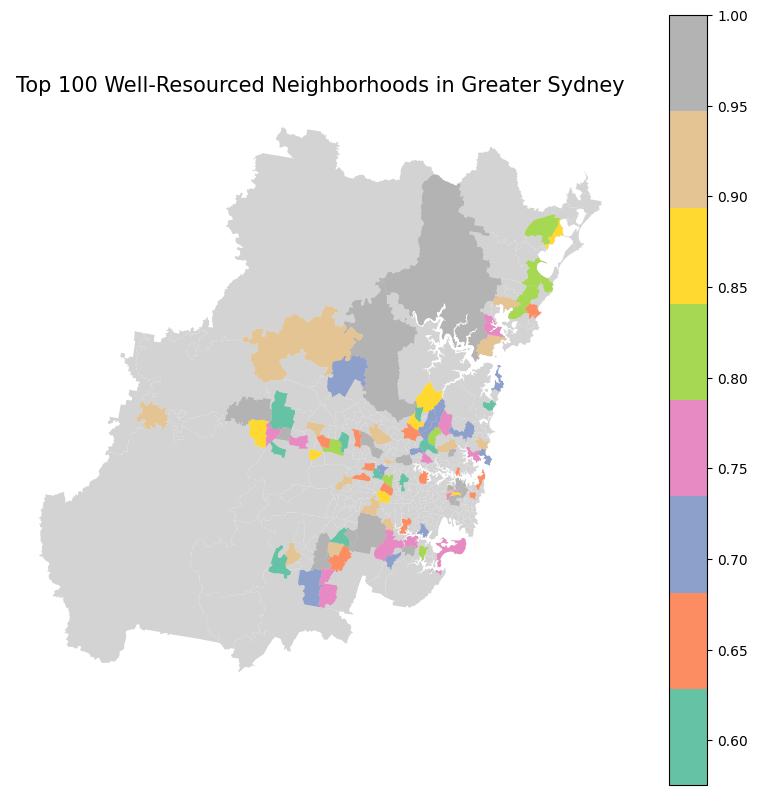

In [126]:
sql_all = """
SELECT sa2."SA2_NAME21", sa2.geom
FROM sa2
"""

sql_top_100 = """
SELECT sa2."SA2_NAME21",
    sa2.geom,
    ns.score
FROM sa2
JOIN new_scores ns ON sa2."SA2_CODE21" = ns.sa2_code
ORDER BY ns.score DESC
LIMIT 100
"""

all_neighborhoods = gpd.read_postgis(sql_all, conn, geom_col='geom', crs=4326)

top_20_neighborhoods = gpd.read_postgis(sql_top_100, conn, geom_col='geom', crs=4326)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

all_neighborhoods.plot(ax=ax, color='lightgrey')
top_20_neighborhoods.plot(ax=ax, column='score', cmap='Set2', legend=True)
ax.set_title("Top 100 Well-Resourced Neighborhoods in Greater Sydney", fontsize=15)
ax.set_axis_off()
plt.show()

In [127]:
#correlation between score and median income
df = pd.DataFrame(new_scores[['sa2_code','sa2_name', 'score', 'median_income']])
df

,sa2_code,sa2_name,score,median_income
0,102011028,Avoca Beach - Copacabana,0.207027,55065
1,102011029,Box Head - MacMasters Beach,0.396857,51927
2,102011030,Calga - Kulnura,1.000000,49168
3,102011031,Erina - Green Point,0.832741,51905
4,102011032,Gosford - Springfield,0.930575,54372
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0.770617,67381
356,128021538,Sutherland - Kirrawee,0.954811,64940
357,128021607,Engadine,0.689805,63695
358,128021608,Loftus - Yarrawarrah,0.207364,63087


In [ ]:
print(df.dtypes)

sa2_code           int64
sa2_name          object
score            float64
median_income     object
dtype: object


In [ ]:
df['median_income'] = pd.to_numeric(df['median_income'], errors='coerce')
df

,sa2_code,sa2_name,score,median_income
0,102011028,Avoca Beach - Copacabana,0.207027,55065
1,102011029,Box Head - MacMasters Beach,0.396857,51927
2,102011030,Calga - Kulnura,1.000000,49168
3,102011031,Erina - Green Point,0.832741,51905
4,102011032,Gosford - Springfield,0.930575,54372
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0.770617,67381
356,128021538,Sutherland - Kirrawee,0.954811,64940
357,128021607,Engadine,0.689805,63695
358,128021608,Loftus - Yarrawarrah,0.207364,63087


In [ ]:
correlation = df['score'].corr(df['median_income'])
print(correlation)

0.0369234241465603


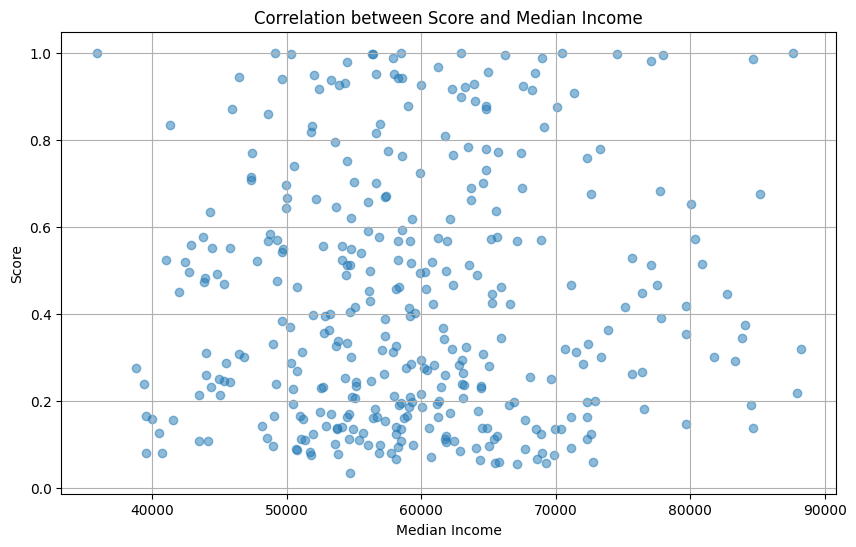

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['median_income'], df['score'], alpha=0.5)
plt.title('Correlation between Score and Median Income')
plt.xlabel('Median Income')
plt.ylabel('Score')
plt.grid(True)
plt.show()

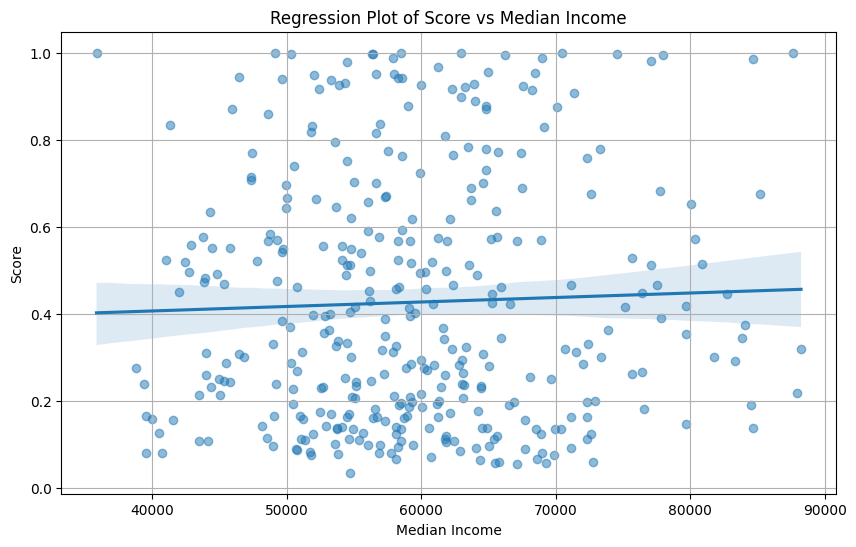

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.regplot(x='median_income', y='score', data=df, scatter_kws={'alpha':0.5})
plt.title('Regression Plot of Score vs Median Income')
plt.xlabel('Median Income')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [ ]:

#conn.close()
#db.dispose()